<img src="https://www.mines.edu/webcentral/wp-content/uploads/sites/267/2019/02/horizontallightbackground.jpg" width="100%"> 

### CSCI250 Python Computing: Building a Sensor System
<hr style="height:5px" width="100%" align="left">

# LAB: Recording studio 
## Sam Burton

# Introduction

The goal for this lab is to collect a large volume of data from all output pins of a microphone and store them in `numpy` arrays. 

Once the recording is complete, you will perform basic data analysis, storage and visualization. 

<img src="https://www.dropbox.com/s/u628vjn2uc5h3ua/notebook.png?raw=1" width="10%" align="right">

Read through
* the [GPIO notebook](h_GPIO.ipynb) to learn about the General Purpose IO interface;
* the [ADC notebook](h_ADC.ipynb)  to learn how to measure analog voltages;
* the [microphone notebook](h_Microphone.ipynb) to learn about a device with both digital and analog outputs;
* the [flex sensor notebook](h_FlexSensor.ipynb) to learn about a device with analog output.

**Build the circuits in all notebooks to ensure that everything works correctly.**

# Pre-lab questions

### Microphone
1. How must the microphone be wired in order to use it?
    * Audio to ADC channel 1 or 0, Envelope to the other ADC channel, Gate to Sparkfun channel G(pin number), UCC to voltage, GND to ground.
2. How do the different analog outputs of the microphone represent?
    * The audio output returns raw voltage from the sound the microphone picks up, and the envelope output returns the voltage that tracks the peaks of the audio output.
3. What is the meaning of the microphone "gate"?
    * The gate pin returns 1 when sound is detected, and 0 when sound is not detected.
    
### Flex Sensor
1. How must the flex sensor be wired in order to use it?
    * Thick pin to voltage, other pin to ADC channel with resistor connected to ground in the middle.
2. Why is it necessary to use a separate ADCs for the flex sensor?
    * The microphone requires both ADC channels to run properly, so there is no room left on one ADC to also add a flex sensor.
3. What is the expected flex sensor resistance range?
    * ~60 to 110 kOhms

# Directions

Your goal for this lab capture analog data provided by a microphone, convert that to digital data, store them on the RPi in `numpy` arrays, and then perform basic data processing and visualization. You will use the flex sensor to control the start and duration of data acquisition.

* Use the flex sensor to triger on and off data collection from the microphone.
    * Start data acquisition when the flex sensor is bent.
    * Stop data acquisition when the flex sensor is straight.
    * Use a threshold resistance to define what "straight sensor" means.
    
* Collect raw data from all microphone pins and store them in `numpy` arrays.
    * Collect data as fast as possible, do not use `time.sleep()` in your loop.
    * Use appending into the `numpy` arrays during the loop.
    * Also collect the measurement time in a separate `numpy` array.

* Plot all the raw data vs. time.
    * Overlap data on the same plot and differentiate them by color.
    * Add axis labels, title and legend.
    
* Save raw data arrays to a file using `numpy.savez()`.

* Load the data from that file into different `numpy` arrays.
    
* Calculate the mean of the audio data, and subtract it to remove the audio bias.
* For periods when the gate pin returns $0$, set the audio data to $0$ to remove noise.

* Plot the modified data vs. time.
    * Overlap data on the same plot and differentiate them by color.
    * Add axis labels, title and legend.

* Apply a moving average filter and moving stdev filter to the envelope data. 
    * You may use an external module for the filters, or write your own filtering code.

* Plot the raw envelope and filtered envelope data as a function of time.
    * Overlap data on the same plot and differentiate them by color.
    * Shade the area between the **mean-stdev** and **mean+stdev** using `plt.fill_between()`.
    * Add axis labels, title and legend.

**Use vectorization instead of loops whenever possible.**

# Your code

No starter code is provided for this lab. Use comments throughout your code so we can understand what it does. Even if you can't figure out how to write the code for something, a comment explaining what you wanted will get partial credit.

In [1]:
# Your code here
#set up ADC channels
import adcUtil as adc
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
#set up microphone

import RPi.GPIO as GPIO

# setup GPIO as input for the gate pin
GPIO.setmode(GPIO.BCM)
gatePin = 27
GPIO.setup(gatePin, GPIO.IN)

#inside while loop...
gateState = GPIO.input(gatePin)
Vaudio    = adc.readADC(channel=0, device=0) 
Venvelope = adc.readADC(channel=1, device=0) 


In [3]:
#set up flex sensor
Vou = adc.readADC(channel=0, device=1) 
# parameters from VDE
Vin =  3.3 # Volt
R2  = 10.0 # kOhm
# flex sensor resistance (by VDE) 
flex = R2 * (Vin/Vou - 1)
straight = 33.347457627118644 ###################################################you can set this parameter based on your own flex sensor here
flex ############################################################################run this cell once and copy and paste the value below into "straight"

33.347457627118644

In [4]:
running = True

audio = []
envelope = []
timeStamp = []
gate = []


while running == True:
    #tell while loop about the sensors
    
    #set up flex sensor
    Vou = adc.readADC(channel=0, device=1) 
    # parameters from VDE
    Vin =  3.3 # Volt
    R2  = 10.0 # kOhm
    # flex sensor resistance (by VDE) 
    flex = R2 * (Vin/Vou - 1)

    #set up microphone
    gateState = GPIO.input(gatePin)
    Vaudio    = adc.readADC(channel=0, device=0) 
    Venvelope = adc.readADC(channel=1, device=0) 

    #if flex sensor is bent, while it is bent record microphone data
    if flex > straight + 20 or flex < straight - 5: #this determines whether the flex sensor is bent

        #use different parameters to record to account for fluctuations between boundaries
        while flex > straight + 10 or flex < straight - 1:
            #tell this while loop about the sensors
            
            #set up flex sensor
            Vou = adc.readADC(channel=0, device=1) 
            # parameters from VDE
            Vin =  3.3 # Volt
            R2  = 10.0 # kOhm
            # flex sensor resistance (by VDE) 
            flex = R2 * (Vin/Vou - 1)

            #set up microphone
            gateState = GPIO.input(gatePin)
            Vaudio    = adc.readADC(channel=0, device=0) 
            Venvelope = adc.readADC(channel=1, device=0) 
                        
            #add inputs from microphone to appropriate arrays
            audio.append(Vaudio)
            envelope.append(Venvelope)
            gate.append(gateState)
            timeStamp.append(time.time())


        #when it is no longer bent, stop running
        if flex < straight + 10 or flex > straight - 1:
            running = False
        

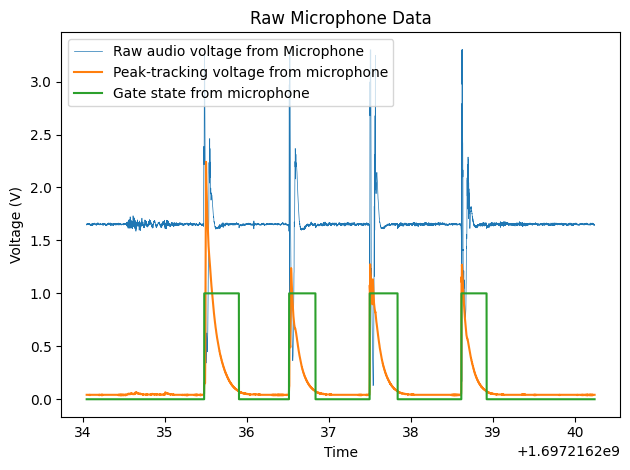

In [5]:
#plot data!!
plt.plot(timeStamp, audio, label="Raw audio voltage from Microphone", linewidth=0.5)

plt.plot(timeStamp, envelope, label="Peak-tracking voltage from microphone")

plt.plot(timeStamp, gate, label="Gate state from microphone")

plt.xlabel("Time")
plt.ylabel("Voltage (V)")
plt.legend()
plt.title("Raw Microphone Data")


plt.tight_layout()

In [6]:
# save to arrays
np.savez("timeStamp.npz", timeStamp)
np.savez("audio.npz", audio)
np.savez("envelope.npz", envelope)
np.savez("gate.npz", gate)


In [7]:
#load files of data into different arrays
recordingTime = np.load('timeStamp.npz')
recordingAud = np.load('audio.npz')
recordingEnv = np.load('envelope.npz')
recordingGate = np.load('gate.npz')

#convert to floats
recordingTime = recordingTime['arr_0'].astype(float)
recordingAud = recordingAud['arr_0'].astype(float)
recordingEnv = recordingEnv['arr_0'].astype(float)
recordingGate = recordingGate['arr_0'].astype(int)


In [8]:
#remove audio bias using mean
meanAud = np.mean(recordingAud)

recordingAud = recordingAud - meanAud

In [9]:
#For periods when the gate pin returns 0, set the audio data to 0 to remove noise.

recordingAud = recordingAud * recordingGate

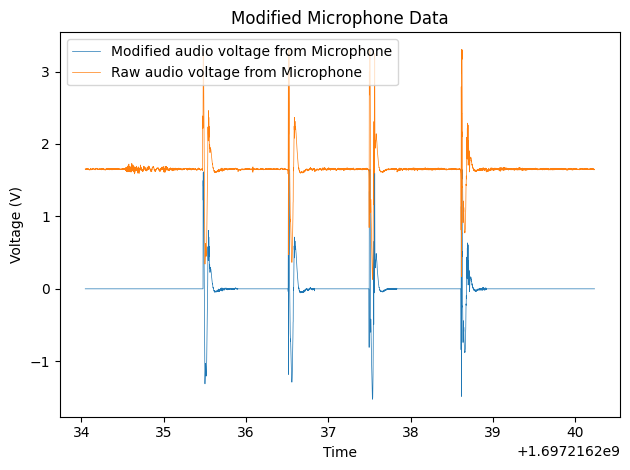

In [10]:
#plot data!!
plt.plot(recordingTime, recordingAud, label="Modified audio voltage from Microphone", linewidth=0.5)

plt.plot(recordingTime, audio, label="Raw audio voltage from Microphone", linewidth=0.5)

plt.xlabel("Time")
plt.ylabel("Voltage (V)")
plt.legend()
plt.title("Modified Microphone Data")


plt.tight_layout()

In [70]:
#Apply a moving average filter and moving stdev filter to the envelope data.

#make recordingEnv a Pandas dataframe

recordingEnvDF = pd.DataFrame(recordingEnv, columns = ['Env'])

#calculate rolling average and std with a large enough window to see the difference between lines on the plot

movingAvEnv = recordingEnvDF['Env'].rolling(200, min_periods=1).mean()
movingSTDEnv = recordingEnvDF['Env'].rolling(200, min_periods=1).std()

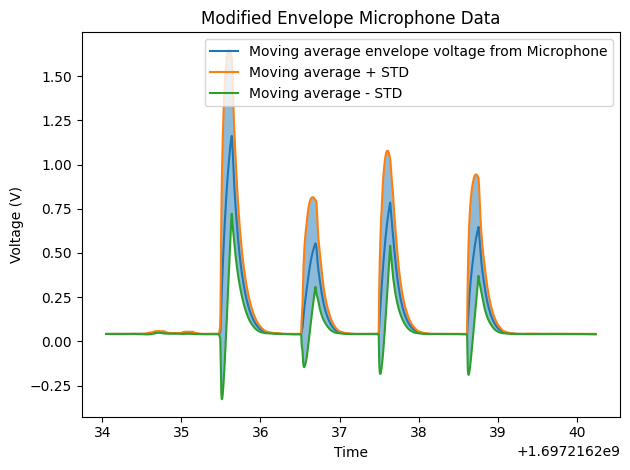

In [69]:
#plot data!!
plt.plot(recordingTime, movingAvEnv, label="Moving average envelope voltage from Microphone")

plt.plot(recordingTime, movingAvEnv + movingSTDEnv, label="Moving average + STD")

plt.plot(recordingTime, movingAvEnv - movingSTDEnv, label = "Moving average - STD")

plt.xlabel("Time")
plt.ylabel("Voltage (V)")
plt.legend()
plt.title("Modified Envelope Microphone Data")
plt.fill_between(recordingTime, movingAvEnv + movingSTDEnv, movingAvEnv - movingSTDEnv, alpha=0.5)


plt.tight_layout()

# Post lab

<img src="http://www.dropbox.com/s/fcucolyuzdjl80k/todo.jpg?raw=1" width="10%" align="right">

Before you submit the lab, make sure everything works as you expect by restarting the kernel: select **Kernel > Restart & Run All**.

Answer the following questions.

1. What elements of this lab did you find easy/challenging?
    * I struggled to make the microphone continue recording when the flex sensor is still bent. It took me a long time in office hours to realize (with TA help) that the conditions for the microphone to start recording (if statement) do not have to be the same as the parameters to continue recording (while loop).
2. What did you like/dislike about this lab?
    * I liked building the circuit for this lab. It is complicated, but I found the way I organized it to be satisfying.
3. If you did anything worthy of extra credit, tell us about it here!
    * I just followed the lab instructions.

# Submit
* Make sure to update your name and department in the top markdown cell.

* Rename the Jupyter notebook with the following convention:
**HL?-FirstLast.ipynb** (replace ? with the lab number)

* Turn in your Jupyter notebook on Canvas. Email submissions don't count.

* Include pictures of all the circuits you made.

![Circuit](HL3_circuit.jpg)

# Honor code
Unless explicitly specified, labs are **individual exercises**. Your submission is subject to the [**Mines Honor Code**](http://inside.mines.edu/~epoeter/_GW/CSMHonorCodeUndergradHandbook.pdf).